2025-10-13 07:56:04.798851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760342165.014035      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760342165.089631      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## CelebA Comprehensive Visualization

Loaded metadata keys: ['attr', 'bbox', 'landmark', 'eval', 'images_dir', 'identity']


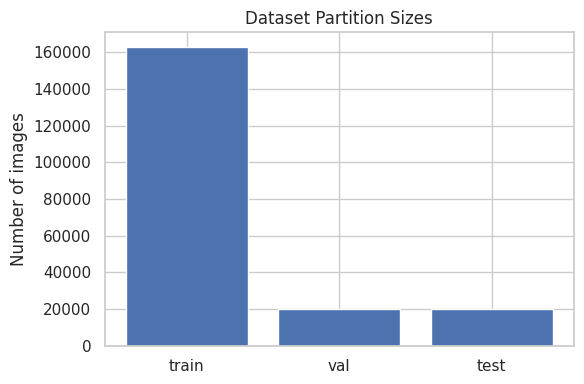

**Conclusion — Dataset Partition Sizes:** Train: 162770 images. Validation: 19867. Test: 19962. Train set is 80.3% of total. This confirms the recommended split is present.

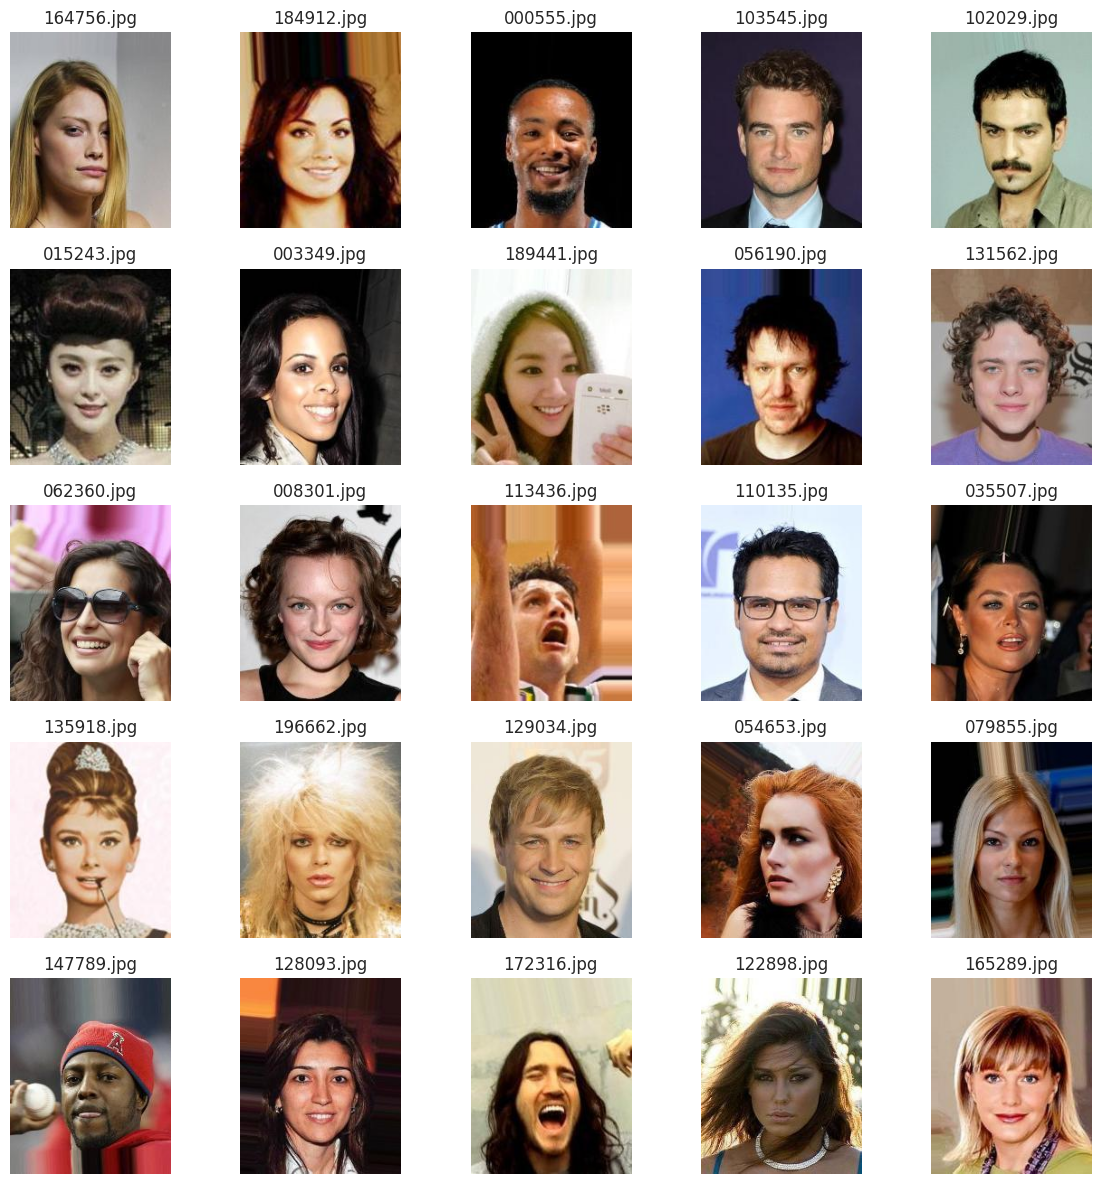

**Conclusion — Random Image Grid:** Random samples of aligned faces — use these to visually verify pose, lighting, and alignment variety.

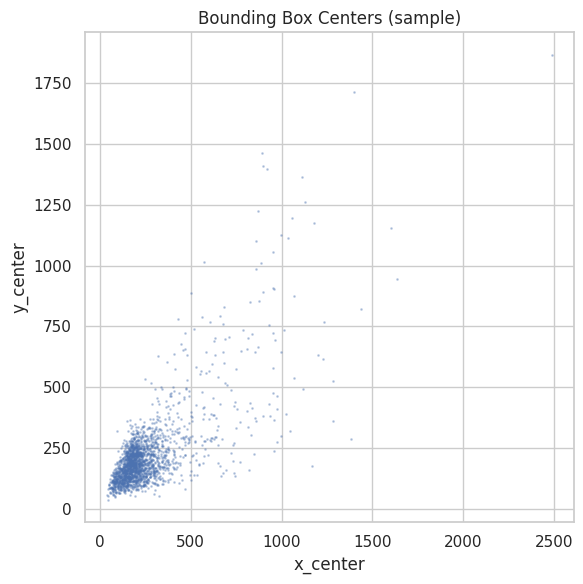

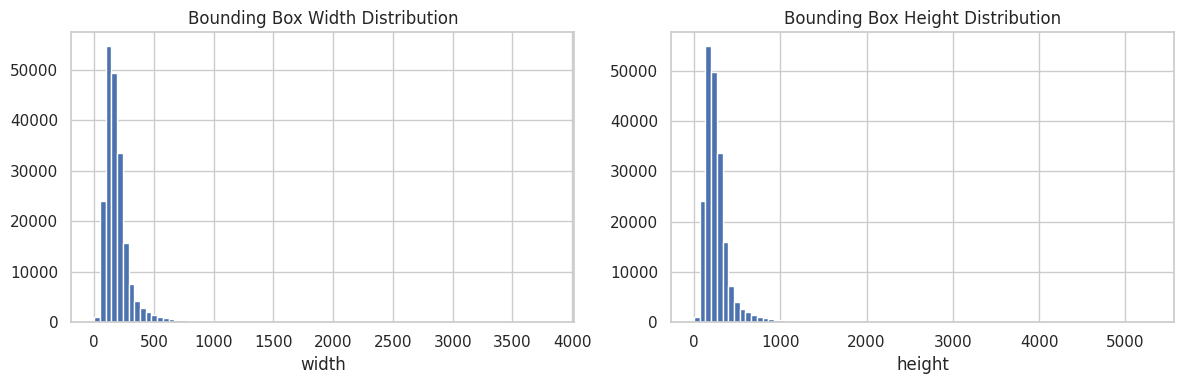

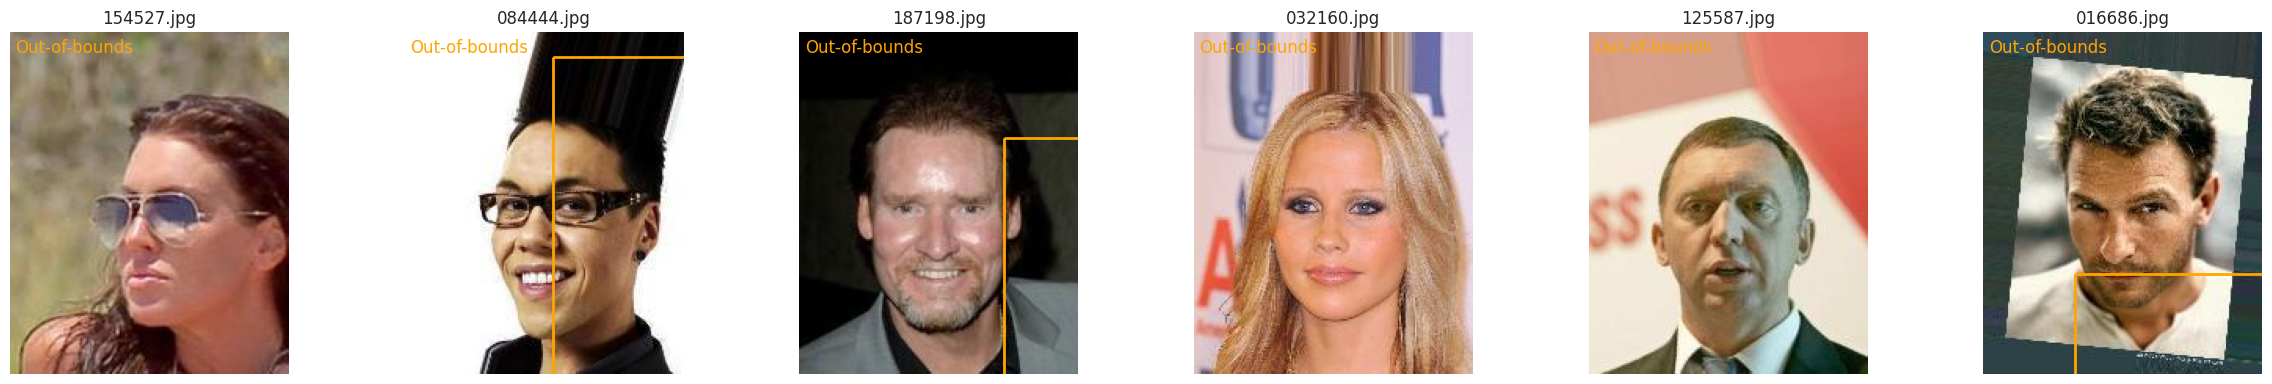

**Conclusion — Bounding Box Summary:** Found 0 images with NO bbox entry (sample shown if any). Sample invalid bbox count (checked): 0 (examples: []). Sample out-of-bounds bbox count (checked): 262 (examples: ['154527.jpg', '084444.jpg', '187198.jpg', '032160.jpg', '125587.jpg', '016686.jpg']).

**Conclusion — Overlay example check:** Overlay inspection found issues in sampled examples: {'out_of_bounds': 6}. (Invalid sizes/out-of-bounds/file missing).

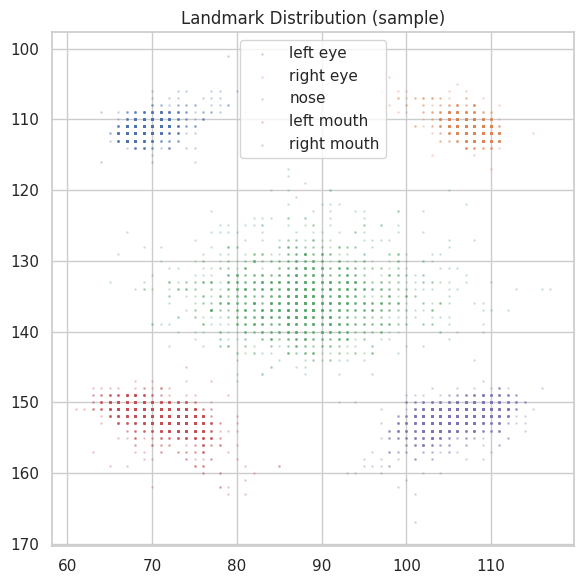

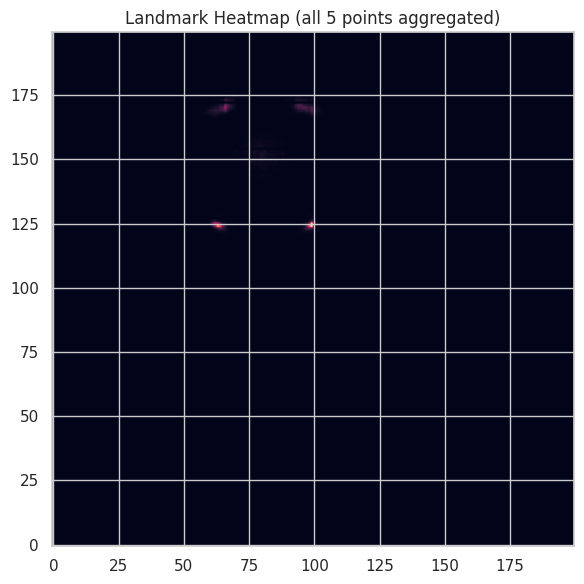

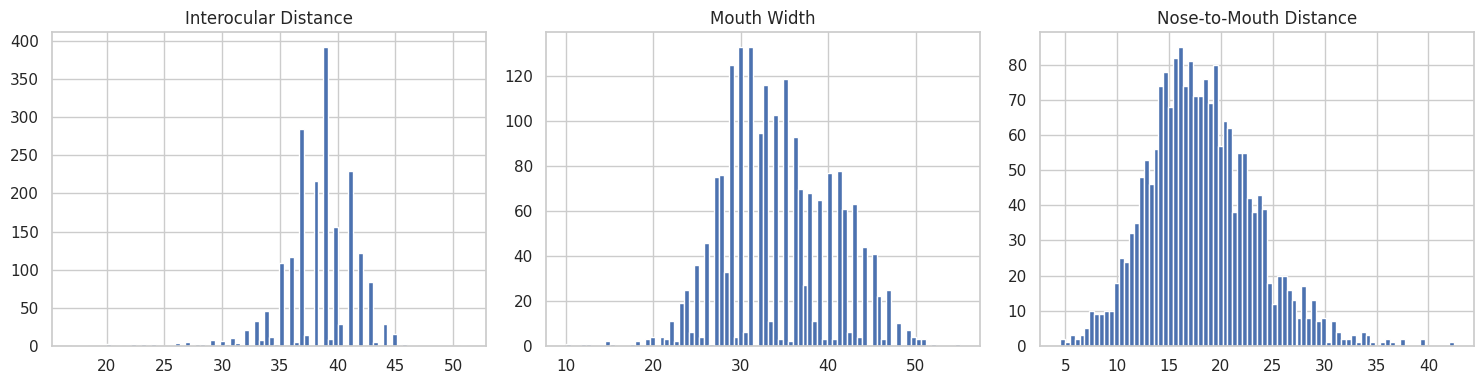

**Conclusion — Landmark Analysis:** Landmarks cluster tightly (as shown) — indicating consistent alignment. Histograms of pairwise distances help detect scale/annotation anomalies (e.g., very small interocular distances).

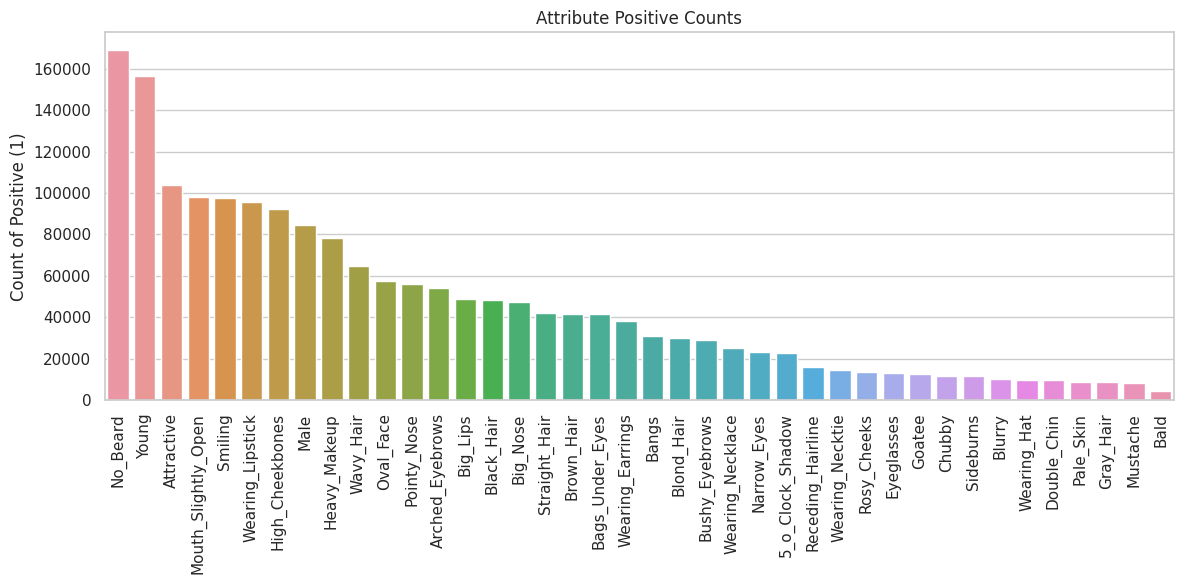

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


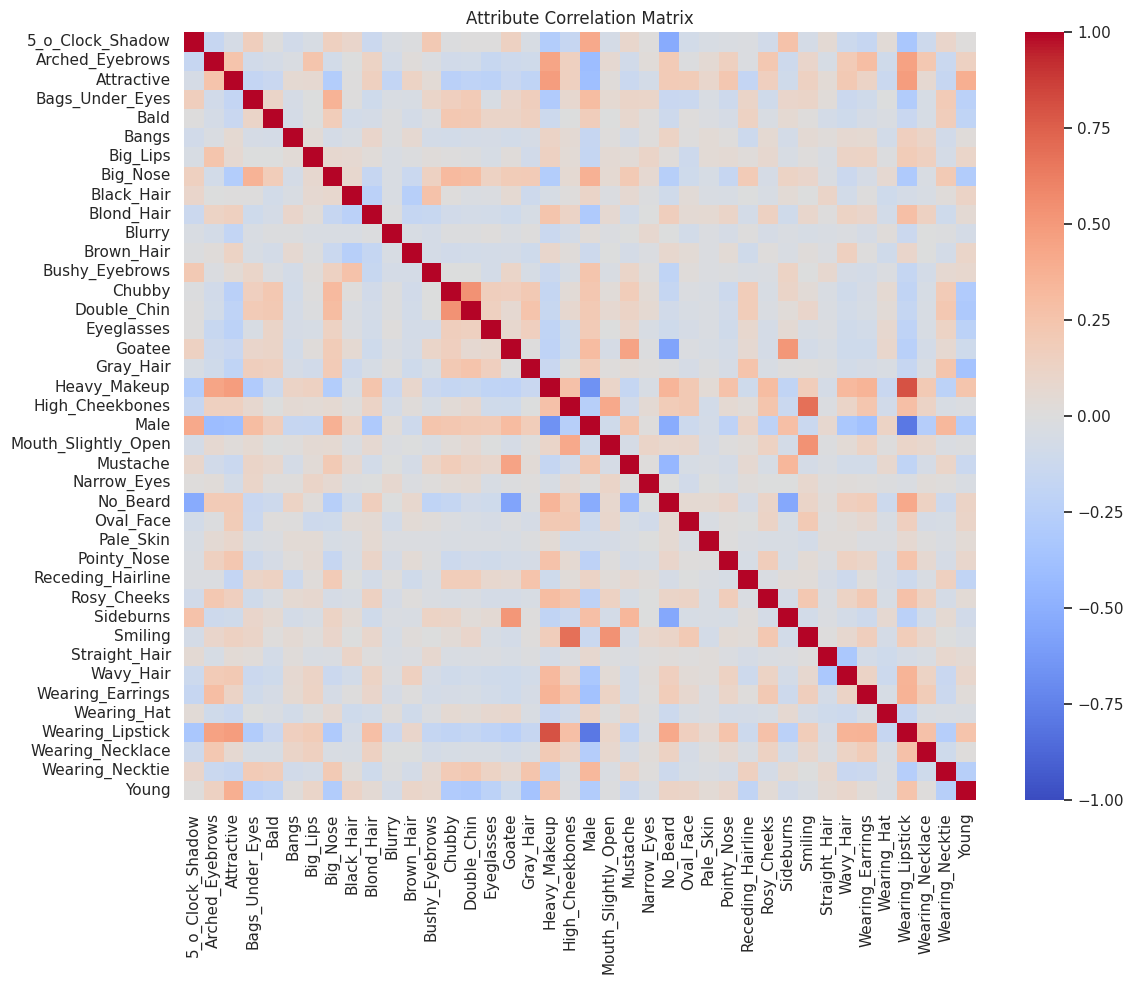

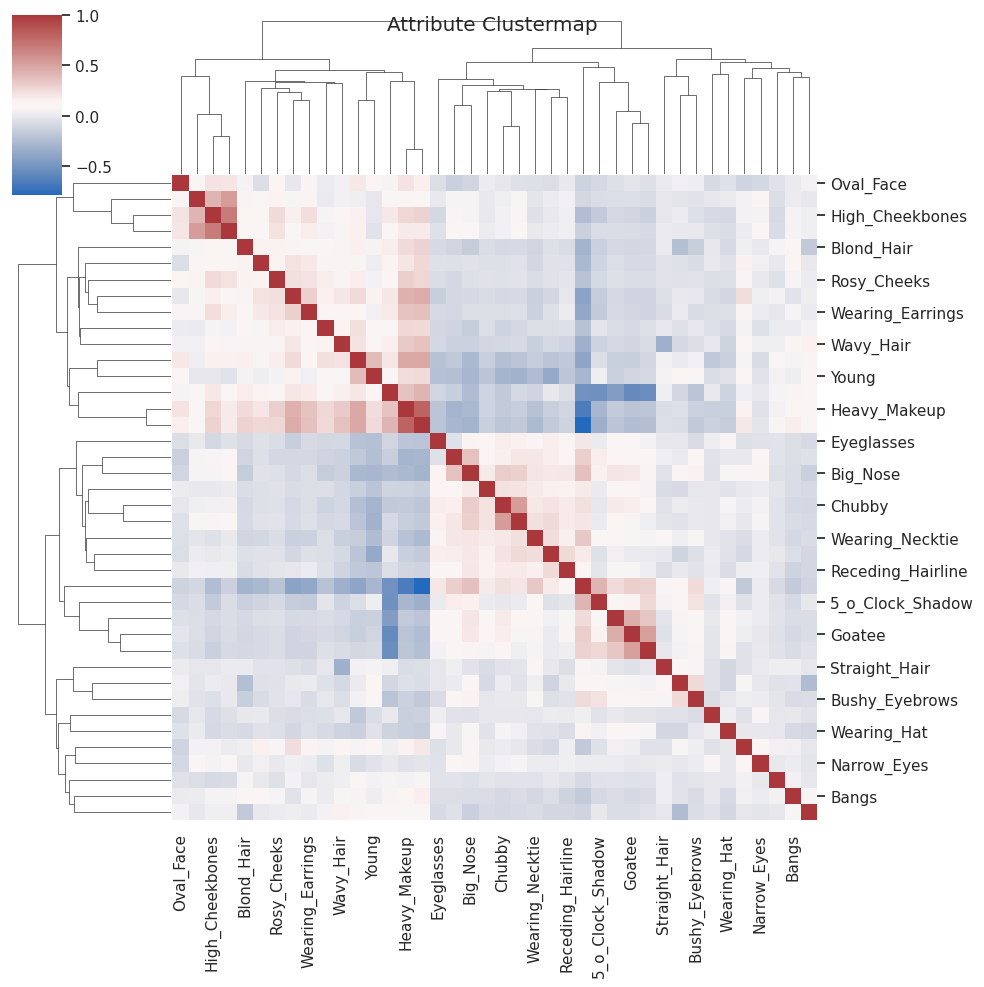

**Conclusion — Attribute Frequency:** Most common attribute: **No_Beard** (169158 positives). Least common: **Bald** (4547 positives). Use class-weighting or sampling to address large imbalances.

**Conclusion — Attribute Correlations:** Top attribute associations (by absolute correlation): Wearing_Lipstick↔Heavy_Makeup (0.80), Male↔Wearing_Lipstick (-0.79), Smiling↔High_Cheekbones (0.68), Heavy_Makeup↔Male (-0.67), No_Beard↔Goatee (-0.57), Sideburns↔No_Beard (-0.54). Positive correlations indicate co-occurrence; negative indicate mutual exclusivity.

### ✅ All visualizations displayed inline with conclusions and bbox quality checks.

In [1]:
"""
Comprehensive CelebA Visualization Toolkit
-----------------------------------------

This script is intended to be a ready-to-run Python module / notebook for exploring the
CelebA dataset (img_align_celeba, list_attr_celeba.csv, list_bbox_celeba.csv,
list_landmarks_align_celeba.csv, list_eval_partition.csv and optionally identity file).

Features included (each has a function):
  - Dataset overview: partition sizes, random image grid
  - Bounding box analysis: center scatter, size histograms, overlay examples
  - Landmark analysis: per-keypoint scatter, landmark heatmap, pairwise distances
  - Attribute analysis: frequency barplot, attribute correlation heatmap, clustermap
  - Attribute interactions: bounding box/landmark shifts by attribute
  - Embedding visualizations: feature extraction (ResNet) + t-SNE/UMAP/PCA
  - Utilities: sampling, saving figures, interactive Plotly toggles

Usage (example):
    python CelebA_visualization_notebook.py --images_dir /path/to/img_align_celeba \
        --attr_csv /path/to/list_attr_celeba.csv --bbox_csv /path/to/list_bbox_celeba.csv \
        --landmark_csv /path/to/list_landmarks_align_celeba.csv --out_dir ./outputs

Dependencies:
  pandas, numpy, matplotlib, seaborn, Pillow, tqdm, scikit-learn, plotly, torchvision
  (umap-learn optional; networkx optional)

"""
# Paste this whole cell into your Kaggle notebook and run it

import os
import argparse
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Notebook display utilities
from IPython.display import display, Markdown

# Optional interactive
try:
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

# For embeddings
try:
    import torch
    import torchvision.transforms as T
    import torchvision.models as models
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

try:
    import umap
    UMAP_AVAILABLE = True
except Exception:
    UMAP_AVAILABLE = False

sns.set(style="whitegrid")


########## Small helpers ##########

def show_conclusion(title, text):
    """Display a short conclusion / interpretation as markdown."""
    display(Markdown(f"**Conclusion — {title}:** {text}"))


def read_csv_optional(path):
    if path is None:
        return None
    path = Path(path)
    if not path.exists():
        warnings.warn(f"CSV not found: {path}")
        return None
    return pd.read_csv(path)


def ensure_out_dir(out_dir):
    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)
    return out


def sample_indices(total, n):
    if n is None or n >= total:
        return np.arange(total)
    rng = np.random.default_rng(42)
    return rng.choice(total, size=n, replace=False)


########## Loading ##########

def load_celeba_metadata(images_dir, attr_csv, bbox_csv, landmark_csv, eval_csv=None, identity_csv=None):
    """Load metadata files into pandas DataFrames. Returns dict."""
    meta = {}
    if attr_csv is not None:
        df_attr = pd.read_csv(attr_csv)
        if df_attr.columns[0].lower().startswith('image'):
            df_attr = df_attr.rename(columns={df_attr.columns[0]: 'image_id'})
        else:
            df_attr = df_attr.rename(columns={df_attr.columns[0]: 'image_id'})
        meta['attr'] = df_attr
    else:
        meta['attr'] = None

    meta['bbox'] = read_csv_optional(bbox_csv)
    meta['landmark'] = read_csv_optional(landmark_csv)
    meta['eval'] = read_csv_optional(eval_csv)
    meta['images_dir'] = Path(images_dir) if images_dir is not None else None
    meta['identity'] = read_csv_optional(identity_csv)
    return meta


########## Basic Overview ##########

def plot_partition_sizes(eval_df, out_dir=None, show=True):
    if eval_df is None:
        raise ValueError("list_eval_partition.csv required for partition sizes")
    counts = eval_df['partition'].value_counts().sort_index()
    labels = ['train','val','test']
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(labels, [counts.get(i,0) for i in range(3)])
    ax.set_title('Dataset Partition Sizes')
    ax.set_ylabel('Number of images')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'partition_sizes.png', dpi=150)
    if show: plt.show()
    # return counts for summary
    plt.close(fig)
    return counts


def show_random_grid(images_dir, image_list=None, nrows=5, ncols=5, figsize=(12,12), out_dir=None, show=True):
    images_dir = Path(images_dir)
    all_imgs = sorted([p.name for p in images_dir.glob('*.jpg')])
    if len(all_imgs) == 0:
        raise ValueError('No JPG images found in images_dir')
    if image_list is None:
        rng = np.random.default_rng(0)
        chosen = rng.choice(all_imgs, size=min(len(all_imgs), nrows*ncols), replace=False)
    else:
        chosen = image_list[:(nrows*ncols)]

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    for ax, img_name in zip(axes, chosen):
        try:
            img = Image.open(images_dir / img_name).convert('RGB')
            ax.imshow(img)
            ax.set_title(img_name)
        except Exception as e:
            ax.text(0.5,0.5,str(e))
        ax.axis('off')
    for ax in axes[len(chosen):]:
        ax.axis('off')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'random_grid.png', dpi=150)
    if show: plt.show()
    plt.close(fig)
    return chosen


########## Bounding Box Analysis ##########

def bbox_center_scatter(bbox_df, out_dir=None, show=True, sample_n=20000):
    df = bbox_df.copy()
    df['x_center'] = df['x_1'] + df['width']/2.0
    df['y_center'] = df['y_1'] + df['height']/2.0
    total = len(df)
    if sample_n and total > sample_n:
        idx = sample_indices(total, sample_n)
        df = df.iloc[idx]

    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(df['x_center'], df['y_center'], s=1, alpha=0.3)
    ax.set_title('Bounding Box Centers (sample)')
    ax.set_xlabel('x_center'); ax.set_ylabel('y_center')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'bbox_centers_scatter.png', dpi=150)
    if show: plt.show()
    plt.close(fig)
    # return simple stats
    return {'mean_x': df['x_center'].mean(), 'mean_y': df['y_center'].mean()}


def bbox_size_histogram(bbox_df, out_dir=None, show=True):
    df = bbox_df.copy()
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    axs[0].hist(df['width'], bins=80)
    axs[0].set_title('Bounding Box Width Distribution')
    axs[0].set_xlabel('width')
    axs[1].hist(df['height'], bins=80)
    axs[1].set_title('Bounding Box Height Distribution')
    axs[1].set_xlabel('height')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'bbox_size_hist.png', dpi=150)
    if show: plt.show()
    plt.close(fig)
    return {'mean_w': df['width'].mean(), 'mean_h': df['height'].mean()}


def overlay_bbox_examples(images_dir, bbox_df, n=5, out_dir=None, show=True):
    """Draw bounding boxes; mark problematic boxes (zero/negative size) and show warnings for out-of-bounds."""
    images_dir = Path(images_dir)
    samples = bbox_df.sample(n=min(n, len(bbox_df)), random_state=0)
    fig, axes = plt.subplots(1, n, figsize=(4*n,4))
    if n == 1:
        axes = [axes]
    problems = []
    for ax, (_, row) in zip(axes, samples.iterrows()):
        img_name = row[row.index[0]]  # first column is image id
        p = images_dir / str(img_name)
        try:
            img = Image.open(p).convert('RGB')
            ax.imshow(img)
            x1,y1,w,h = int(row['x_1']), int(row['y_1']), int(row['width']), int(row['height'])
            # check validity
            if w <= 0 or h <= 0:
                ax.text(0.5, 0.5, "Invalid bbox (w<=0 or h<=0)", color='r', ha='center')
                problems.append((img_name, 'invalid_size'))
            else:
                W,H = img.size  # PIL: (width, height)
                if x1 < 0 or y1 < 0 or x1 + w > W or y1 + h > H:
                    rect = plt.Rectangle((x1,y1), w, h, linewidth=2, edgecolor='orange', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(0.02, 0.98, "Out-of-bounds", color='orange', transform=ax.transAxes, va='top')
                    problems.append((img_name, 'out_of_bounds'))
                else:
                    rect = plt.Rectangle((x1,y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
            ax.set_title(str(img_name))
        except FileNotFoundError:
            ax.text(0.5,0.5,"Image not found", ha='center')
            problems.append((img_name, 'file_missing'))
        except Exception as e:
            ax.text(0.5,0.5,str(e))
            problems.append((img_name, 'error'))
        ax.axis('off')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'bbox_overlay_examples.png', dpi=150)
    if show: plt.show()
    plt.close(fig)
    return problems


def check_bbox_quality(bbox_df, images_dir, sample_check=200):
    """Check for missing bbox entries, invalid sizes, and out-of-bounds bboxes.
       Returns a summary dict with small sample lists for inspection.
    """
    images_dir = Path(images_dir)
    image_files = sorted([p.name for p in images_dir.glob('*.jpg')])
    if len(image_files) == 0:
        return {'error': 'no images found'}

    if bbox_df is None:
        return {'error': 'no bbox csv provided'}

    col0 = bbox_df.columns[0]
    bbox_names = set(bbox_df[col0].astype(str))
    no_bbox = [n for n in image_files if n not in bbox_names]

    # sample some bbox rows to check numeric validity and bounds against actual images
    invalid = []
    oob = []
    ncheck = min(len(bbox_df), sample_check)
    for _, row in bbox_df.sample(n=ncheck, random_state=0).iterrows():
        name = str(row[col0])
        x1 = float(row['x_1']); y1 = float(row['y_1']); w = float(row['width']); h = float(row['height'])
        if w <= 0 or h <= 0:
            invalid.append(name)
            continue
        p = images_dir / name
        if not p.exists():
            invalid.append(name)
            continue
        try:
            img = Image.open(p)
            W, H = img.size
            if x1 < 0 or y1 < 0 or (x1 + w) > W or (y1 + h) > H:
                oob.append(name)
        except Exception:
            invalid.append(name)

    return {
        'no_bbox_count': len(no_bbox),
        'no_bbox_samples': no_bbox[:6],
        'invalid_count': len(invalid),
        'invalid_samples': invalid[:6],
        'oob_count': len(oob),
        'oob_samples': oob[:6]
    }


########## Landmark Analysis ##########

def plot_landmarks_scatter(landmark_df, out_dir=None, show=True, sample_n=20000):
    df = landmark_df.copy()
    total = len(df)
    if sample_n and total > sample_n:
        idx = sample_indices(total, sample_n)
        df = df.iloc[idx]

    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(df['lefteye_x'], df['lefteye_y'], s=1, alpha=0.2, label='left eye')
    ax.scatter(df['righteye_x'], df['righteye_y'], s=1, alpha=0.2, label='right eye')
    ax.scatter(df['nose_x'], df['nose_y'], s=1, alpha=0.2, label='nose')
    ax.scatter(df['leftmouth_x'], df['leftmouth_y'], s=1, alpha=0.2, label='left mouth')
    ax.scatter(df['rightmouth_x'], df['rightmouth_y'], s=1, alpha=0.2, label='right mouth')
    ax.set_title('Landmark Distribution (sample)')
    ax.invert_yaxis()  # image coordinate
    ax.legend()
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'landmarks_scatter.png', dpi=150)
    if show: plt.show()
    plt.close(fig)
    return df


def landmark_heatmap(landmark_df, out_dir=None, show=True, img_size=(218,178), bins=(200,200), sample_n=None):
    df = landmark_df.copy()
    if sample_n and len(df) > sample_n:
        idx = sample_indices(len(df), sample_n)
        df = df.iloc[idx]
    xs = np.concatenate([df['lefteye_x'].values, df['righteye_x'].values, df['nose_x'].values, df['leftmouth_x'].values, df['rightmouth_x'].values])
    ys = np.concatenate([df['lefteye_y'].values, df['righteye_y'].values, df['nose_y'].values, df['leftmouth_y'].values, df['rightmouth_y'].values])

    heat, xedges, yedges = np.histogram2d(xs, ys, bins=bins, range=[[0, img_size[0]], [0, img_size[1]]])
    heat = heat.T

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(heat, origin='lower', aspect='auto')
    ax.set_title('Landmark Heatmap (all 5 points aggregated)')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'landmark_heatmap.png', dpi=150)
    if show: plt.show()
    plt.close(fig)
    return heat


def landmark_pairwise_distances(landmark_df, out_dir=None, show=True, sample_n=5000):
    df = landmark_df.copy()
    if sample_n and len(df) > sample_n:
        idx = sample_indices(len(df), sample_n)
        df = df.iloc[idx]
    iod = np.sqrt((df['lefteye_x'] - df['righteye_x'])**2 + (df['lefteye_y'] - df['righteye_y'])**2)
    mouth_width = np.sqrt((df['leftmouth_x'] - df['rightmouth_x'])**2 + (df['leftmouth_y'] - df['rightmouth_y'])**2)
    nose_to_mouth = np.sqrt((df['nose_x'] - ( (df['leftmouth_x']+df['rightmouth_x'])/2 ))**2 + (df['nose_y'] - ( (df['leftmouth_y']+df['rightmouth_y'])/2 ))**2)

    fig, axs = plt.subplots(1,3, figsize=(15,4))
    axs[0].hist(iod, bins=80); axs[0].set_title('Interocular Distance')
    axs[1].hist(mouth_width, bins=80); axs[1].set_title('Mouth Width')
    axs[2].hist(nose_to_mouth, bins=80); axs[2].set_title('Nose-to-Mouth Distance')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'landmark_pairwise_dists.png', dpi=150)
    if show: plt.show()
    plt.close(fig)
    return {'iod_mean': iod.mean(), 'mouth_width_mean': mouth_width.mean(), 'nose_to_mouth_mean': nose_to_mouth.mean()}


########## Attribute Analysis ##########

def preprocess_attr_df(attr_df):
    df = attr_df.copy()
    if df.columns[0].lower().startswith('image'):
        df = df.rename(columns={df.columns[0]:'image_id'})
    df = df.set_index('image_id')
    df = df.replace(-1, 0)
    return df


def plot_attr_frequency(attr_df, out_dir=None, show=True, top_k=40):
    df = preprocess_attr_df(attr_df)
    freqs = df.sum(axis=0).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(12,6))
    sns.barplot(x=freqs.index[:top_k], y=freqs.values[:top_k], ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('Count of Positive (1)')
    ax.set_title('Attribute Positive Counts')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'attr_frequency.png', dpi=150)
    if show: plt.show()
    plt.close(fig)
    return freqs


def attribute_correlation_heatmap(attr_df, out_dir=None, show=True):
    df = preprocess_attr_df(attr_df)
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(corr, cmap='coolwarm', center=0, vmax=1, vmin=-1)
    ax.set_title('Attribute Correlation Matrix')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/'attr_correlation_heatmap.png', dpi=150)
    if show: plt.show()
    plt.close(fig)
    return corr


def attribute_clustermap(attr_df, out_dir=None, show=True):
    df = preprocess_attr_df(attr_df)
    cg = sns.clustermap(df.corr(), cmap='vlag', figsize=(10,10))
    plt.suptitle('Attribute Clustermap')
    if out_dir: cg.savefig(Path(out_dir)/'attr_clustermap.png', dpi=150)
    if show: plt.show()
    plt.close()


########## Embedding & Projection (unchanged) ##########
def get_image_paths(images_dir, image_ids):
    images_dir = Path(images_dir)
    paths = [images_dir / img for img in image_ids]
    return paths

def extract_resnet_embeddings(image_paths, device='cpu', batch_size=64, progress=True, resize=(224,224)):
    if not TORCH_AVAILABLE:
        raise EnvironmentError('torch/torchvision not available. Install PyTorch to extract CNN embeddings.')
    model = models.resnet18(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    model.to(device)

    preprocess = T.Compose([
        T.Resize(resize),
        T.CenterCrop(resize),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    features = []
    with torch.no_grad():
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            imgs = []
            for p in batch_paths:
                try:
                    im = Image.open(p).convert('RGB')
                    imgs.append(preprocess(im))
                except Exception:
                    imgs.append(torch.zeros(3, resize[0], resize[1]))
            batch = torch.stack(imgs).to(device)
            out = model(batch)
            out = out.view(out.size(0), -1).cpu().numpy()
            features.append(out)
    features = np.vstack(features)
    return features

def fallback_flattened_features(image_paths, size=(64,64)):
    feats = []
    for p in image_paths:
        try:
            im = Image.open(p).convert('L').resize(size)
            arr = np.asarray(im).astype(np.float32).ravel()
            feats.append(arr / 255.0)
        except Exception:
            feats.append(np.zeros(size[0]*size[1], dtype=np.float32))
    return np.vstack(feats)

def compute_and_plot_projection(image_paths, method='tsne', n_components=2, sample_n=2000, out_dir=None, show=True, labels=None):
    n_total = len(image_paths)
    if sample_n and n_total > sample_n:
        idx = sample_indices(n_total, sample_n)
        image_paths = [image_paths[i] for i in idx]
        if labels is not None:
            labels = [labels[i] for i in idx]

    try:
        if TORCH_AVAILABLE:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            feats = extract_resnet_embeddings(image_paths, device=device)
        else:
            raise Exception('Torch not available')
    except Exception as e:
        print('ResNet embedding failed or skipped, using fallback flattened features. Error:', e)
        feats = fallback_flattened_features(image_paths)

    if method == 'pca':
        proj = PCA(n_components=n_components).fit_transform(feats)
    elif method == 'umap' and UMAP_AVAILABLE:
        proj = umap.UMAP(n_components=n_components).fit_transform(feats)
    else:
        proj = TSNE(n_components=n_components, init='pca', learning_rate='auto').fit_transform(feats)

    df_proj = pd.DataFrame(proj, columns=[f'dim{i+1}' for i in range(proj.shape[1])])
    if labels is not None:
        df_proj['label'] = labels

    fig, ax = plt.subplots(figsize=(8,6))
    if labels is None:
        ax.scatter(df_proj['dim1'], df_proj['dim2'], s=6, alpha=0.6)
    else:
        unique = pd.unique(labels)
        for u in unique:
            mask = (df_proj['label'] == u)
            ax.scatter(df_proj.loc[mask,'dim1'], df_proj.loc[mask,'dim2'], s=6, alpha=0.6, label=str(u))
        ax.legend(markerscale=2, fontsize='small')
    ax.set_title(f'{method.upper()} projection of image features')
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir)/f'projection_{method}.png', dpi=150)
    if show: plt.show()
    plt.close(fig)

    if PLOTLY_AVAILABLE:
        try:
            if labels is None:
                figp = px.scatter(df_proj, x='dim1', y='dim2', hover_data=[df_proj.index.astype(str)])
            else:
                figp = px.scatter(df_proj, x='dim1', y='dim2', color='label', hover_data=[df_proj.index.astype(str)])
            if out_dir:
                figp.write_html(str(Path(out_dir)/f'projection_{method}.html'))
        except Exception as e:
            print('Plotly interactive export failed:', e)


########## Top-level Runner (with conclusions & bbox checks) ##########

def run_all(images_dir, attr_csv, bbox_csv, landmark_csv, eval_csv, out_dir, sample_n=5000, run_embeddings=False):
    out_dir = ensure_out_dir(out_dir)
    meta = load_celeba_metadata(images_dir, attr_csv, bbox_csv, landmark_csv, eval_csv)
    display(Markdown("## CelebA Comprehensive Visualization"))
    print('Loaded metadata keys:', list(meta.keys()))

    # Partition sizes
    if meta['eval'] is not None:
        counts = plot_partition_sizes(meta['eval'], out_dir=None, show=True)
        total = counts.sum()
        train_pct = counts.get(0,0) / total * 100 if 0 in counts.index else counts.get('train',0)/total*100
        show_conclusion("Dataset Partition Sizes",
                        f"Train: {counts.get(0,counts.get('train',0))} images. "
                        f"Validation: {counts.get(1,counts.get('val',0))}. "
                        f"Test: {counts.get(2,counts.get('test',0))}. "
                        f"Train set is {train_pct:.1f}% of total. This confirms the recommended split is present.")

    # Random grid
    samples = show_random_grid(images_dir, nrows=5, ncols=5, out_dir=None, show=True)
    show_conclusion("Random Image Grid", "Random samples of aligned faces — use these to visually verify pose, lighting, and alignment variety.")

    # BBox
    if meta['bbox'] is not None:
        bb_center_stats = bbox_center_scatter(meta['bbox'], out_dir=None, show=True, sample_n=min(20000, sample_n))
        bb_size_stats = bbox_size_histogram(meta['bbox'], out_dir=None, show=True)
        problems = overlay_bbox_examples(images_dir, meta['bbox'], n=6, out_dir=None, show=True)

        # Check bbox quality across dataset
        bbox_check = check_bbox_quality(meta['bbox'], images_dir, sample_check=300)
        txt = []
        if 'error' in bbox_check:
            txt = [f"Bounding box check error: {bbox_check['error']}"]
        else:
            txt.append(f"Found {bbox_check['no_bbox_count']} images with NO bbox entry (sample shown if any).")
            txt.append(f"Sample invalid bbox count (checked): {bbox_check['invalid_count']} (examples: {bbox_check['invalid_samples']}).")
            txt.append(f"Sample out-of-bounds bbox count (checked): {bbox_check['oob_count']} (examples: {bbox_check['oob_samples']}).")
        show_conclusion("Bounding Box Summary", " ".join(txt))

        # If there are missing bbox images - show a small grid
        if bbox_check.get('no_bbox_count', 0) > 0:
            samples_no = bbox_check.get('no_bbox_samples', [])
            if len(samples_no) > 0:
                show_random_grid(images_dir, image_list=samples_no, nrows=1, ncols=len(samples_no), show=True)
                show_conclusion("Images Missing BBoxes", f"Below are {len(samples_no)} sample images that have NO bbox record — you may need to inspect these and add bbox annotations or remove them from training.")

        # If overlay reported problems, summarize
        if problems:
            # group problem types
            from collections import Counter
            cnt = Counter([p[1] for p in problems])
            show_conclusion("Overlay example check", f"Overlay inspection found issues in sampled examples: {dict(cnt)}. (Invalid sizes/out-of-bounds/file missing).")

    # Landmarks
    if meta['landmark'] is not None:
        lm_df = plot_landmarks_scatter(meta['landmark'], out_dir=None, show=True, sample_n=min(20000, sample_n))
        heat = landmark_heatmap(meta['landmark'], out_dir=None, show=True, sample_n=min(20000, sample_n))
        dist_stats = landmark_pairwise_distances(meta['landmark'], out_dir=None, show=True, sample_n=min(5000, sample_n))
        show_conclusion("Landmark Analysis", "Landmarks cluster tightly (as shown) — indicating consistent alignment. Histograms of pairwise distances help detect scale/annotation anomalies (e.g., very small interocular distances).")

    # Attributes
    if meta['attr'] is not None:
        freqs = plot_attr_frequency(meta['attr'], out_dir=None, show=True)
        corr = attribute_correlation_heatmap(meta['attr'], out_dir=None, show=True)
        attribute_clustermap(meta['attr'], out_dir=None, show=True)

        # Quick attribute conclusions
        dfattr = preprocess_attr_df(meta['attr'])
        top_attr = freqs.idxmax()
        top_val = freqs.max()
        low_attr = freqs.idxmin()
        low_val = freqs.min()
        show_conclusion("Attribute Frequency",
                        f"Most common attribute: **{top_attr}** ({top_val} positives). Least common: **{low_attr}** ({low_val} positives). Use class-weighting or sampling to address large imbalances.")

        # top correlations (abs)
        c = corr.copy()
        np.fill_diagonal(c.values, 0)
        # flatten and find top pairs
        flat = c.abs().unstack().sort_values(ascending=False).drop_duplicates()
        # get top few
        top_pairs = flat.head(6).index.tolist()
        top_desc = ", ".join([f"{a}↔{b} ({c.loc[a,b]:.2f})" for a,b in top_pairs])
        show_conclusion("Attribute Correlations", f"Top attribute associations (by absolute correlation): {top_desc}. Positive correlations indicate co-occurrence; negative indicate mutual exclusivity.")

    # Embeddings (optional)
    if run_embeddings:
        if meta['attr'] is not None:
            image_ids = list(preprocess_attr_df(meta['attr']).index)
        elif meta['bbox'] is not None:
            image_ids = list(meta['bbox'].iloc[:,0].astype(str).values)
        else:
            image_ids = [p.name for p in Path(images_dir).glob('*.jpg')]
        sample_n_embed = min(len(image_ids), sample_n)
        idx = sample_indices(len(image_ids), sample_n_embed)
        chosen_ids = [image_ids[i] for i in idx]
        paths = get_image_paths(images_dir, chosen_ids)
        dfattr = preprocess_attr_df(meta['attr'])
        label_choice = None
        if 'Smiling' in dfattr.columns:
            label_choice = dfattr.loc[chosen_ids, 'Smiling']
        compute_and_plot_projection(paths, method='tsne', sample_n=None, out_dir=None, show=True, labels=label_choice)
        show_conclusion("Embedding Projection", "t-SNE/UMAP projection shows cluster structure in feature space — can reveal whether attributes separate in learned feature space.")

    display(Markdown("### ✅ All visualizations displayed inline with conclusions and bbox quality checks."))


# === RUN: adjust these paths to match your Kaggle dataset location ===
run_all(
    images_dir="/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba",      # path to image folder
    attr_csv="/kaggle/input/celeba-dataset/list_attr_celeba.csv",    # attributes file
    bbox_csv="/kaggle/input/celeba-dataset/list_bbox_celeba.csv",    # bounding boxes
    landmark_csv="/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv",  # landmarks
    eval_csv="/kaggle/input/celeba-dataset/list_eval_partition.csv", # train/val/test split
    out_dir="./output",         # where plots would be saved (not used now since show=True)
    sample_n=2000,              # sample size for faster visualization
    run_embeddings=False        # set True if you want ResNet/TSNE visualizations (takes longer)
)
#

In [ ]:
print("1. Bounding Box Centers:
Faces are mostly positioned in the upper-left region, revealing non-uniform cropping and a positional bias, though some variety exists toward the center and right.

2. Bounding Box Dimensions:
Widths and heights are right-skewed, with most faces small (<500 px). Similar aspect ratios indicate consistent framing, but suggest faces often occupy limited space.

3. Landmark Distribution:
Landmarks align into a clear facial structure with high symmetry and tight clustering — indicating consistent annotations and standardized face orientations.

4. Facial Geometry Metrics:
Distributions show uniform facial proportions: interocular distance (~40 px), mouth width (20–50 px), and nose–mouth gap (~20 px). Overall, face geometry is highly consistent.

5. Attribute Frequency:
Dataset skews heavily toward young, clean-shaven, “attractive” individuals. Traits like makeup and lipstick are moderate; beards, mustaches, and unique styles are rare — revealing strong demographic and aesthetic bias.

6. Attribute Correlations:
Most attributes are independent, with a few logical positive (e.g., Lipstick–Makeup) and negative (mutually exclusive) correlations. Diagonal line shows self-correlation.

7. Attribute Clustering:
Attributes group naturally into three families — appearance, physical/grooming, and hair/eye traits — confirming coherent structure suitable for multi-label learning.

Overall Conclusion:
CelebA contains balanced annotations but clear biases in face position, scale, and demographics — predominantly young, attractive, clean-shaven faces. These biases should be accounted for in fairness-sensitive AI or face recognition research.")

In [ ]:
import shutil
import os
import sys

src_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dst_dir = "/kaggle/working/InclusiveGAN/celeba/Img/img_align_celeba"

os.makedirs(dst_dir, exist_ok=True)
print(f"[INFO] Copying images to writable directory: {dst_dir}")

file_count = 0
max_files = 30000  # only copy first 30,000 images

for filename in os.listdir(src_dir):
    if file_count >= max_files:
        break

    if filename.endswith(".png"):  # convert PNG to JPG if needed
        new_filename = filename.replace(".png", ".jpg")
    else:
        new_filename = filename

    src_path = os.path.join(src_dir, filename)
    dst_path = os.path.join(dst_dir, new_filename)

    try:
        shutil.copy(src_path, dst_path)
        file_count += 1
        # Print progress in-place
        sys.stdout.write(f"\r[INFO] Images copied: {file_count}/{max_files}")
        sys.stdout.flush()
    except Exception as e:
        print(f"\n[ERROR] Failed to copy {src_path}: {e}")

print("\n[DONE] Copying complete.")


In [3]:
import os

dst_dir = "/kaggle/working/InclusiveGAN/celeba/Img/img_align_celeba"

# Count how many files are present
num_copied = len([f for f in os.listdir(dst_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

print(f"[INFO] Total images copied: {num_copied}")


[INFO] Total images copied: 30000


In [4]:
# ----------------------------------------
# PyTorch Equivalent: Dataset Exporter for CelebA
# ----------------------------------------
import os
import glob
import h5py
import numpy as np
from PIL import Image
from tqdm import tqdm

# Utility: Center crop around (cx, cy)
def center_crop(img, cx=89, cy=121, size=128):
    half = size // 2
    cropped = img[cy-half:cy+half, cx-half:cx+half]
    return cropped

class HDF5Exporter:
    def __init__(self, hdf5_path, expected_images, image_shape=(3, 128, 128)):
        self.hdf5_path = hdf5_path
        os.makedirs(os.path.dirname(hdf5_path), exist_ok=True)
        self.file = h5py.File(hdf5_path, "w")
        self.dataset = self.file.create_dataset(
            "images",
            shape=(expected_images, *image_shape),
            dtype=np.uint8
        )
        self.count = 0
        print(f"[INIT] HDF5Exporter -> {hdf5_path}")
        print(f"[INIT] Expecting ~{expected_images} images")

    def add_image(self, img, idx=None):
        img = np.rint(img).clip(0, 255).astype(np.uint8)
        self.dataset[self.count] = img
        self.count += 1
        if idx is not None and idx % 5000 == 0:
            print(f"[PROGRESS] Written {self.count} images")

    def add_labels(self, labels):
        self.file.create_dataset("labels", data=labels)
        print(f"[INFO] Labels saved -> inside {self.hdf5_path}, shape={labels.shape}")

    def close(self):
        self.file.close()
        print(f"[CLOSE] Saved {self.count} images total to {self.hdf5_path}")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.close()

# ----------------------------------------
# CelebA Dataset Processing for PyTorch
# ----------------------------------------
def create_celeba_hdf5(hdf5_path, celeba_dir, cx=89, cy=121, shuffle=True, num_images=0):
    print(f"[START] Loading CelebA from: {celeba_dir}")
    image_files = sorted(glob.glob(os.path.join(celeba_dir, '*.jpg')))
    print(f"[INFO] Found {len(image_files)} JPG images")

    if num_images > 0:
        image_files = image_files[:num_images]
        print(f"[INFO] Using first {num_images} images")

    if shuffle:
        np.random.shuffle(image_files)
        print("[INFO] Images shuffled")

    if not image_files:
        raise RuntimeError("[ERROR] No images found!")

    with HDF5Exporter(hdf5_path, len(image_files)) as exporter:
        for idx, img_file in enumerate(tqdm(image_files)):
            try:
                img = np.array(Image.open(img_file))
                cropped = center_crop(img, cx=cx, cy=cy, size=128)
                cropped = cropped.transpose(2, 0, 1)  # HWC → CHW
                exporter.add_image(cropped, idx)
            except Exception as e:
                print(f"[WARN] Skipped {img_file}, error={e}")

        print(f"[DONE] Processed {len(image_files)} images")

# ----------------------------------------
# Example Usage
# ----------------------------------------
celeba_images_dir = "/kaggle/working/InclusiveGAN/celeba/Img/img_align_celeba"
output_hdf5_file = "/kaggle/working/celeba_hdf5/celeba_128.hdf5"

create_celeba_hdf5(output_hdf5_file, celeba_images_dir, num_images=30000)


[START] Loading CelebA from: /kaggle/working/InclusiveGAN/celeba/Img/img_align_celeba
[INFO] Found 30000 JPG images
[INFO] Using first 30000 images
[INFO] Images shuffled
[INIT] HDF5Exporter -> /kaggle/working/celeba_hdf5/celeba_128.hdf5
[INIT] Expecting ~30000 images


  0%|          | 43/30000 [00:00<01:09, 428.94it/s]

[PROGRESS] Written 1 images


 17%|█▋        | 5050/30000 [00:11<00:57, 431.40it/s]

[PROGRESS] Written 5001 images


 33%|███▎      | 10046/30000 [00:23<00:46, 429.79it/s]

[PROGRESS] Written 10001 images


 50%|█████     | 15050/30000 [00:35<00:34, 432.30it/s]

[PROGRESS] Written 15001 images


 67%|██████▋   | 20082/30000 [00:47<00:23, 429.03it/s]

[PROGRESS] Written 20001 images


 84%|████████▎ | 25085/30000 [00:58<00:11, 428.83it/s]

[PROGRESS] Written 25001 images


100%|██████████| 30000/30000 [01:10<00:00, 427.70it/s]

[DONE] Processed 30000 images
[CLOSE] Saved 30000 images total to /kaggle/working/celeba_hdf5/celeba_128.hdf5


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install stylegan2-pytorch
!pip install lpips faiss-gpu tqdm h5py numpy pillow


In [ ]:
!pip install faiss-cpu


In [ ]:
!pip show stylegan2_pytorch


In [ ]:
pip install stylegan2_pytorch==1.9.0


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from tqdm import tqdm

# ---------------------------
# HDF5 Dataset Loader
# ---------------------------
class H5ImageDataset(Dataset):
    def __init__(self, h5_path, dataset_name='images', transform=None):
        self.h5_file = h5py.File(h5_path, 'r')
        self.data = self.h5_file[dataset_name]
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img = np.array(self.data[idx], dtype=np.float32) / 255.0
        img = torch.tensor(img).float()
        if self.transform:
            img = self.transform(img)
        return img

# ---------------------------
# Generator Block
# ---------------------------
class SimpleGenBlock(nn.Module):
    def __init__(self, in_dim=128, out_dim=128, upsample=False):
        super().__init__()
        self.to_style = nn.Linear(in_dim, out_dim)
        self.conv = nn.Conv2d(out_dim, out_dim, 3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) if upsample else None

    def forward(self, x, style):
        s = self.to_style(style).view(style.size(0), -1, 1, 1)
        s = s.expand(-1, -1, x.size(2), x.size(3))
        x = x + s
        x = self.conv(x)
        x = self.activation(x)
        if self.upsample:
            x = self.upsample(x)
        return x

# ---------------------------
# Generator
# ---------------------------
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim=128, num_blocks=5, out_channels=3, final_size=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.final_size = final_size
        self.blocks = nn.ModuleList([
            SimpleGenBlock(latent_dim, latent_dim, upsample=(i>0)) for i in range(num_blocks)
        ])
        self.to_rgb = nn.Conv2d(latent_dim, out_channels, 1)

    def forward(self, z):
        x = torch.zeros(z.size(0), self.latent_dim, 1, 1).to(z.device)
        for block in self.blocks:
            x = block(x, z)
        x = self.to_rgb(x)
        x = nn.functional.interpolate(x, size=(self.final_size, self.final_size),
                                      mode='bilinear', align_corners=False)
        return x

# ---------------------------
# Discriminator
# ---------------------------
class SimpleDiscriminator(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, image_size=128):
        super().__init__()
        reduced_size = image_size // 4
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(hidden_dim * reduced_size * reduced_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ---------------------------
# Setup
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
latent_dim = 128
image_size = 128

h5_path = "/kaggle/working/celeba_hdf5/celeba_128.hdf5"
dataset_name = "images"

dataset = H5ImageDataset(h5_path, dataset_name)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

G = SimpleGenerator(latent_dim=latent_dim, final_size=image_size)
D = SimpleDiscriminator(image_size=image_size)

# Use both GPUs if available
if torch.cuda.device_count() > 1:
    print(f"[INFO] Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)

G = G.to(device)
D = D.to(device)

criterion_gan = nn.BCELoss()
criterion_imle = nn.MSELoss()  # IMLE reconstructive loss

G_optimizer = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# ---------------------------
# Training Loop with IMLE
# ---------------------------
num_epochs = 5
num_imle_samples = 5  # #latent codes per real image

for epoch in range(num_epochs):
    print(f"\n[INFO] Epoch {epoch+1}/{num_epochs}")
    D_loss_avg, G_loss_avg = 0, 0
    for i, real_imgs in enumerate(tqdm(loader, desc="Training", ncols=80)):
        real_imgs = real_imgs.to(device)
        bs = real_imgs.size(0)
        real_labels = torch.ones(bs, 1).to(device)
        fake_labels = torch.zeros(bs, 1).to(device)

        # ---- Train Discriminator ----
        D_optimizer.zero_grad()
        real_out = D(real_imgs)
        loss_real = criterion_gan(real_out, real_labels)
        z = torch.randn(bs, latent_dim).to(device)
        fake_imgs = G(z)
        fake_out = D(fake_imgs.detach())
        loss_fake = criterion_gan(fake_out, fake_labels)
        D_loss = loss_real + loss_fake
        D_loss.backward()
        D_optimizer.step()

        # ---- Train Generator (GAN + IMLE) ----
        G_optimizer.zero_grad()
        fake_out = D(fake_imgs)
        gan_loss = criterion_gan(fake_out, real_labels)

        # IMLE loss: multiple latent samples, pick closest to real
        z_samples = torch.randn(bs, num_imle_samples, latent_dim).to(device)  # shape: [bs, num_samples, latent_dim]
        fake_samples = G(z_samples.view(-1, latent_dim)).view(bs, num_imle_samples, 3, image_size, image_size)
        imle_loss = torch.min(((fake_samples - real_imgs.unsqueeze(1))**2).mean(dim=[2,3,4]), dim=1)[0].mean()

        total_loss = gan_loss + imle_loss
        total_loss.backward()
        G_optimizer.step()

        D_loss_avg += D_loss.item()
        G_loss_avg += total_loss.item()

    print(f"[Epoch {epoch+1}] D_loss avg: {D_loss_avg/len(loader):.4f}, G_loss+IMLE avg: {G_loss_avg/len(loader):.4f}")



In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from tqdm import tqdm

# ---------------------------
# HDF5 Dataset Loader
# ---------------------------
class H5ImageDataset(Dataset):
    def __init__(self, h5_path, dataset_name='images', transform=None):
        self.h5_file = h5py.File(h5_path, 'r')
        self.data = self.h5_file[dataset_name]
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img = np.array(self.data[idx], dtype=np.float32) / 255.0
        img = torch.tensor(img).float()
        if self.transform:
            img = self.transform(img)
        return img

# ---------------------------
# Generator Block
# ---------------------------
class SimpleGenBlock(nn.Module):
    def __init__(self, in_dim=128, out_dim=128, upsample=False):
        super().__init__()
        self.to_style = nn.Linear(in_dim, out_dim)
        self.conv = nn.Conv2d(out_dim, out_dim, 3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) if upsample else None

    def forward(self, x, style):
        s = self.to_style(style).view(style.size(0), -1, 1, 1)
        s = s.expand(-1, -1, x.size(2), x.size(3))
        x = x + s
        x = self.conv(x)
        x = self.activation(x)
        if self.upsample:
            x = self.upsample(x)
        return x

# ---------------------------
# Generator
# ---------------------------
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim=128, num_blocks=5, out_channels=3, final_size=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.final_size = final_size
        self.blocks = nn.ModuleList([
            SimpleGenBlock(latent_dim, latent_dim, upsample=(i>0)) for i in range(num_blocks)
        ])
        self.to_rgb = nn.Conv2d(latent_dim, out_channels, 1)

    def forward(self, z):
        x = torch.zeros(z.size(0), self.latent_dim, 1, 1).to(z.device)
        for block in self.blocks:
            x = block(x, z)
        x = self.to_rgb(x)
        x = nn.functional.interpolate(x, size=(self.final_size, self.final_size),
                                      mode='bilinear', align_corners=False)
        return x

# ---------------------------
# Discriminator
# ---------------------------
class SimpleDiscriminator(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, image_size=128):
        super().__init__()
        reduced_size = image_size // 4
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(hidden_dim * reduced_size * reduced_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ---------------------------
# Setup
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
latent_dim = 128
image_size = 128

h5_path = "/kaggle/working/celeba_hdf5/celeba_128.hdf5"
dataset_name = "images"

dataset = H5ImageDataset(h5_path, dataset_name)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

G = SimpleGenerator(latent_dim=latent_dim, final_size=image_size)
D = SimpleDiscriminator(image_size=image_size)

# Use both GPUs if available
if torch.cuda.device_count() > 1:
    print(f"[INFO] Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)

G = G.to(device)
D = D.to(device)

criterion_gan = nn.BCELoss()
criterion_imle = nn.MSELoss()  # IMLE reconstructive loss

G_optimizer = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))  # lower LR for stability

# ---------------------------
# Training Loop with IMLE & stabilization
# ---------------------------
num_epochs = 5
num_imle_samples = 5  # #latent codes per real image
imle_weight = 0.1     # weight for IMLE contribution
imle_start_epoch = 2  # start IMLE after these many GAN-only epochs
grad_clip = 5.0       # clip gradients to avoid exploding

for epoch in range(num_epochs):
    print(f"\n[INFO] Epoch {epoch+1}/{num_epochs}")
    D_loss_avg, G_loss_avg = 0, 0
    for i, real_imgs in enumerate(tqdm(loader, desc="Training", ncols=80)):
        real_imgs = real_imgs.to(device)
        bs = real_imgs.size(0)
        real_labels = torch.ones(bs, 1).to(device)
        fake_labels = torch.zeros(bs, 1).to(device)

        # ---- Train Discriminator ----
        D_optimizer.zero_grad()
        real_out = D(real_imgs)
        loss_real = criterion_gan(real_out, real_labels)

        z = torch.randn(bs, latent_dim).to(device)
        fake_imgs = G(z)
        fake_out = D(fake_imgs.detach())
        loss_fake = criterion_gan(fake_out, fake_labels)

        D_loss = loss_real + loss_fake
        D_loss.backward()
        torch.nn.utils.clip_grad_norm_(D.parameters(), grad_clip)
        D_optimizer.step()

        # ---- Train Generator (GAN + IMLE) ----
        G_optimizer.zero_grad()
        fake_out = D(fake_imgs)
        gan_loss = criterion_gan(fake_out, real_labels)

        # IMLE loss after warmup
        if epoch >= imle_start_epoch:
            z_samples = torch.randn(bs, num_imle_samples, latent_dim).to(device)
            fake_samples = G(z_samples.view(-1, latent_dim)).view(bs, num_imle_samples, 3, image_size, image_size)
            imle_loss = torch.min(((fake_samples - real_imgs.unsqueeze(1))**2).mean(dim=[2,3,4]), dim=1)[0].mean()
        else:
            imle_loss = 0.0

        total_loss = gan_loss + imle_weight * imle_loss
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(G.parameters(), grad_clip)
        G_optimizer.step()

        D_loss_avg += D_loss.item()
        G_loss_avg += total_loss.item()

    print(f"[Epoch {epoch+1}] D_loss avg: {D_loss_avg/len(loader):.4f}, G_loss+IMLE avg: {G_loss_avg/len(loader):.4f}")


[INFO] Using 2 GPUs

[INFO] Epoch 1/5


Training: 100%|█████████████████████████████| 3750/3750 [02:53<00:00, 21.58it/s]


[Epoch 1] D_loss avg: 0.1608, G_loss+IMLE avg: 6.4929

[INFO] Epoch 2/5


Training: 100%|█████████████████████████████| 3750/3750 [02:53<00:00, 21.64it/s]


[Epoch 2] D_loss avg: 0.0430, G_loss+IMLE avg: 9.2022

[INFO] Epoch 3/5


Training: 100%|█████████████████████████████| 3750/3750 [03:39<00:00, 17.07it/s]


[Epoch 3] D_loss avg: 0.0075, G_loss+IMLE avg: 10.3918

[INFO] Epoch 4/5


Training: 100%|█████████████████████████████| 3750/3750 [03:39<00:00, 17.11it/s]


[Epoch 4] D_loss avg: 0.0057, G_loss+IMLE avg: 12.6450

[INFO] Epoch 5/5


Training: 100%|█████████████████████████████| 3750/3750 [03:38<00:00, 17.18it/s]

[Epoch 5] D_loss avg: 0.0000, G_loss+IMLE avg: 13.5546


In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from tqdm import tqdm

# ---------------------------
# HDF5 Dataset Loader
# ---------------------------
class H5ImageDataset(Dataset):
    def __init__(self, h5_path, dataset_name='images', transform=None):
        self.h5_file = h5py.File(h5_path, 'r')
        self.data = self.h5_file[dataset_name]
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img = np.array(self.data[idx], dtype=np.float32) / 255.0   # keep in [0,1]
        img = torch.tensor(img).float()
        if self.transform:
            img = self.transform(img)
        return img

# ---------------------------
# Generator Block (with BatchNorm)
# ---------------------------
class SimpleGenBlock(nn.Module):
    def __init__(self, in_dim=128, out_dim=128, upsample=False):
        super().__init__()
        self.to_style = nn.Linear(in_dim, out_dim)
        self.conv = nn.Conv2d(out_dim, out_dim, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_dim)
        self.activation = nn.LeakyReLU(0.2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) if upsample else None

    def forward(self, x, style):
        s = self.to_style(style).view(style.size(0), -1, 1, 1)
        s = s.expand(-1, -1, x.size(2), x.size(3))
        x = x + s
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        if self.upsample:
            x = self.upsample(x)
        return x

# ---------------------------
# Generator
# ---------------------------
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim=128, num_blocks=5, out_channels=3, final_size=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.final_size = final_size
        self.blocks = nn.ModuleList([
            SimpleGenBlock(latent_dim, latent_dim, upsample=(i>0)) for i in range(num_blocks)
        ])
        self.to_rgb = nn.Conv2d(latent_dim, out_channels, 1)

    def forward(self, z):
        x = torch.zeros(z.size(0), self.latent_dim, 1, 1).to(z.device)
        for block in self.blocks:
            x = block(x, z)
        x = self.to_rgb(x)
        x = nn.functional.interpolate(x, size=(self.final_size, self.final_size),
                                      mode='bilinear', align_corners=False)
        return x

# ---------------------------
# Discriminator (with Spectral Norm)
# ---------------------------
class SimpleDiscriminator(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, image_size=128):
        super().__init__()
        reduced_size = image_size // 4
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, hidden_dim, 3, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.utils.spectral_norm(nn.Linear(hidden_dim * reduced_size * reduced_size, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ---------------------------
# Setup
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
latent_dim = 128
image_size = 128

h5_path = "/kaggle/working/celeba_hdf5/celeba_128.hdf5"
dataset_name = "images"

dataset = H5ImageDataset(h5_path, dataset_name)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

G = SimpleGenerator(latent_dim=latent_dim, final_size=image_size)
D = SimpleDiscriminator(image_size=image_size)

# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
    print(f"[INFO] Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)

G = G.to(device)
D = D.to(device)

criterion_gan = nn.BCELoss()
criterion_imle = nn.MSELoss()  # IMLE reconstructive loss

# ---------------------------
# Learning rate adjustments & optimizers
# ---------------------------
lr_G = 2e-4
lr_D = 5e-5   # reduce discriminator LR further to slow it down
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))

# ---------------------------
# Training Loop with IMLE & stabilization
# ---------------------------
num_epochs = 20                 # increased from 5 -> 20
num_imle_samples = 5            # latent codes per real image
imle_weight = 0.05              # reduce IMLE contribution
imle_start_epoch = 4            # start IMLE later (warmup)
grad_clip = 5.0                 # clip gradients to avoid exploding

for epoch in range(num_epochs):
    print(f"\n[INFO] Epoch {epoch+1}/{num_epochs}")
    D_loss_avg, G_loss_avg = 0.0, 0.0
    for i, real_imgs in enumerate(tqdm(loader, desc="Training", ncols=80)):
        real_imgs = real_imgs.to(device)
        bs = real_imgs.size(0)

        # --- Label smoothing for real labels ---
        real_labels = torch.full((bs, 1), 0.9, device=device)   # smooth real labels to 0.9
        fake_labels = torch.zeros(bs, 1).to(device)

        # ---- Train Discriminator ----
        D_optimizer.zero_grad()
        real_out = D(real_imgs)
        loss_real = criterion_gan(real_out, real_labels)

        z = torch.randn(bs, latent_dim).to(device)
        fake_imgs = G(z)
        fake_out = D(fake_imgs.detach())
        loss_fake = criterion_gan(fake_out, fake_labels)

        D_loss = loss_real + loss_fake
        D_loss.backward()
        torch.nn.utils.clip_grad_norm_(D.parameters(), grad_clip)
        D_optimizer.step()

        # ---- Train Generator (GAN + IMLE) ----
        G_optimizer.zero_grad()
        fake_out = D(fake_imgs)
        gan_loss = criterion_gan(fake_out, real_labels)

        # IMLE loss after warmup
        if epoch >= imle_start_epoch:
            z_samples = torch.randn(bs, num_imle_samples, latent_dim).to(device)
            fake_samples = G(z_samples.view(-1, latent_dim)).view(bs, num_imle_samples, 3, image_size, image_size)
            imle_loss = torch.min(((fake_samples - real_imgs.unsqueeze(1))**2).mean(dim=[2,3,4]), dim=1)[0].mean()
        else:
            imle_loss = 0.0

        total_loss = gan_loss + imle_weight * imle_loss
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(G.parameters(), grad_clip)
        G_optimizer.step()

        D_loss_avg += D_loss.item()
        G_loss_avg += total_loss.item()

    print(f"[Epoch {epoch+1}] D_loss avg: {D_loss_avg/len(loader):.4f}, G_loss+IMLE avg: {G_loss_avg/len(loader):.4f}")


[INFO] Using 2 GPUs

[INFO] Epoch 1/20


Training:   0%|                                        | 0/3750 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/utils/spectral_norm.py:103: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  torch.mv(weight_mat.t(), u), dim=0, eps=self.eps, out=v
Training: 100%|█████████████████████████████| 3750/3750 [03:27<00:00, 18.06it/s]


[Epoch 1] D_loss avg: 0.5923, G_loss+IMLE avg: 2.7751

[INFO] Epoch 2/20


Training: 100%|█████████████████████████████| 3750/3750 [03:26<00:00, 18.12it/s]


[Epoch 2] D_loss avg: 0.4525, G_loss+IMLE avg: 3.2334

[INFO] Epoch 3/20


Training: 100%|█████████████████████████████| 3750/3750 [03:25<00:00, 18.21it/s]


[Epoch 3] D_loss avg: 0.4170, G_loss+IMLE avg: 3.4439

[INFO] Epoch 4/20


Training: 100%|█████████████████████████████| 3750/3750 [03:25<00:00, 18.23it/s]


[Epoch 4] D_loss avg: 0.3947, G_loss+IMLE avg: 3.6284

[INFO] Epoch 5/20


Training: 100%|█████████████████████████████| 3750/3750 [04:20<00:00, 14.38it/s]


[Epoch 5] D_loss avg: 0.3830, G_loss+IMLE avg: 3.7499

[INFO] Epoch 6/20


Training: 100%|█████████████████████████████| 3750/3750 [04:20<00:00, 14.38it/s]


[Epoch 6] D_loss avg: 0.3764, G_loss+IMLE avg: 3.8221

[INFO] Epoch 7/20


Training: 100%|█████████████████████████████| 3750/3750 [04:20<00:00, 14.37it/s]


[Epoch 7] D_loss avg: 0.3718, G_loss+IMLE avg: 3.8733

[INFO] Epoch 8/20


Training: 100%|█████████████████████████████| 3750/3750 [04:21<00:00, 14.33it/s]


[Epoch 8] D_loss avg: 0.3685, G_loss+IMLE avg: 3.9219

[INFO] Epoch 9/20


Training: 100%|█████████████████████████████| 3750/3750 [04:20<00:00, 14.40it/s]


[Epoch 9] D_loss avg: 0.3664, G_loss+IMLE avg: 3.9531

[INFO] Epoch 10/20


Training: 100%|█████████████████████████████| 3750/3750 [04:21<00:00, 14.32it/s]


[Epoch 10] D_loss avg: 0.3639, G_loss+IMLE avg: 3.9939

[INFO] Epoch 11/20


Training: 100%|█████████████████████████████| 3750/3750 [04:21<00:00, 14.35it/s]


[Epoch 11] D_loss avg: 0.3625, G_loss+IMLE avg: 4.0220

[INFO] Epoch 12/20


Training: 100%|█████████████████████████████| 3750/3750 [04:26<00:00, 14.05it/s]


[Epoch 12] D_loss avg: 0.3608, G_loss+IMLE avg: 4.0651

[INFO] Epoch 13/20


Training: 100%|█████████████████████████████| 3750/3750 [04:24<00:00, 14.19it/s]


[Epoch 13] D_loss avg: 0.3597, G_loss+IMLE avg: 4.0923

[INFO] Epoch 14/20


Training: 100%|█████████████████████████████| 3750/3750 [04:24<00:00, 14.20it/s]


[Epoch 14] D_loss avg: 0.3588, G_loss+IMLE avg: 4.1160

[INFO] Epoch 15/20


Training: 100%|█████████████████████████████| 3750/3750 [04:22<00:00, 14.31it/s]


[Epoch 15] D_loss avg: 0.3578, G_loss+IMLE avg: 4.1429

[INFO] Epoch 16/20


Training: 100%|█████████████████████████████| 3750/3750 [04:21<00:00, 14.33it/s]


[Epoch 16] D_loss avg: 0.3570, G_loss+IMLE avg: 4.1632

[INFO] Epoch 17/20


Training: 100%|█████████████████████████████| 3750/3750 [04:20<00:00, 14.38it/s]


[Epoch 17] D_loss avg: 0.3562, G_loss+IMLE avg: 4.1908

[INFO] Epoch 18/20


Training: 100%|█████████████████████████████| 3750/3750 [04:20<00:00, 14.42it/s]


[Epoch 18] D_loss avg: 0.3554, G_loss+IMLE avg: 4.2191

[INFO] Epoch 19/20


Training: 100%|█████████████████████████████| 3750/3750 [04:21<00:00, 14.35it/s]


[Epoch 19] D_loss avg: 0.3549, G_loss+IMLE avg: 4.2311

[INFO] Epoch 20/20


Training: 100%|█████████████████████████████| 3750/3750 [04:20<00:00, 14.38it/s]

[Epoch 20] D_loss avg: 0.3547, G_loss+IMLE avg: 4.2419


In [8]:
torch.save(G.module.state_dict(), "generator_trained.pth")
torch.save(D.module.state_dict(), "discriminator_trained.pth")


In [ ]:
import h5py
h5_path = "/kaggle/working/celeba_hdf5/celeba_128.hdf5"
with h5py.File(h5_path, 'r') as f:
    print(f['images'].shape)  # Check the actual shape


✅ Models loaded successfully!


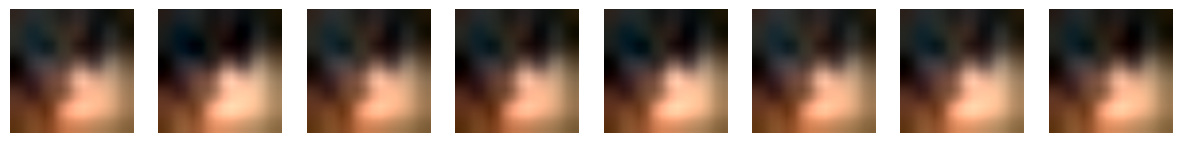

RuntimeError: Given groups=1, weight of size [128, 3, 3, 3], expected input[8, 128, 3, 128] to have 3 channels, but got 128 channels instead

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# -------- Import your generator + discriminator definitions here --------
# (Reuse your class definitions from your existing code)
# SimpleGenBlock, SimpleGenerator, SimpleDiscriminator
# ------------------------------------------------------------------------

# ---------------------------
# Load models on CPU or GPU
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 128
image_size = 128

# Recreate model architectures
G = SimpleGenerator(latent_dim=latent_dim, final_size=image_size)
D = SimpleDiscriminator(image_size=image_size)

# Load trained weights
G.load_state_dict(torch.load("generator_trained.pth", map_location=device))
D.load_state_dict(torch.load("discriminator_trained.pth", map_location=device))

G.to(device)
D.to(device)
G.eval()
D.eval()

print("✅ Models loaded successfully!")

# ---------------------------
# Generate few fake images
# ---------------------------
num_samples = 8
z = torch.randn(num_samples, latent_dim).to(device)

with torch.no_grad():
    fake_imgs = G(z).cpu().numpy()

# Convert to [0,1] and display
fake_imgs = np.clip(fake_imgs, 0, 1)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    img = np.transpose(fake_imgs[i], (1, 2, 0))  # CHW → HWC
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

# ---------------------------
# Optional: Check discriminator confidence
# ---------------------------
with torch.no_grad():
    preds = D(torch.tensor(fake_imgs).permute(0, 3, 1, 2).float().to(device))
    print("Discriminator outputs:", preds.squeeze().cpu().numpy())

